===== Final df_cluster Info =====
<class 'pandas.core.frame.DataFrame'>
Index: 13914 entries, 10072 to 92364
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   C Television                13914 non-null  int64  
 1   C Police                    13914 non-null  int64  
 2   C Courts                    13914 non-null  int64  
 3   C Government                13914 non-null  int64  
 4   C Political parties         13914 non-null  int64  
 5   C Civil services            13914 non-null  int64  
 6   C Elections                 13914 non-null  int64  
 7   Importance of democracy     13914 non-null  int64  
 8   Scale of incomes            13914 non-null  int64  
 9   Strong Leader               13914 non-null  int64  
 10  Expert Non Govt Person      13914 non-null  int64  
 11  Highest educational level   13914 non-null  int64  
 12  Sex                         13914 non-null  int64  
 13

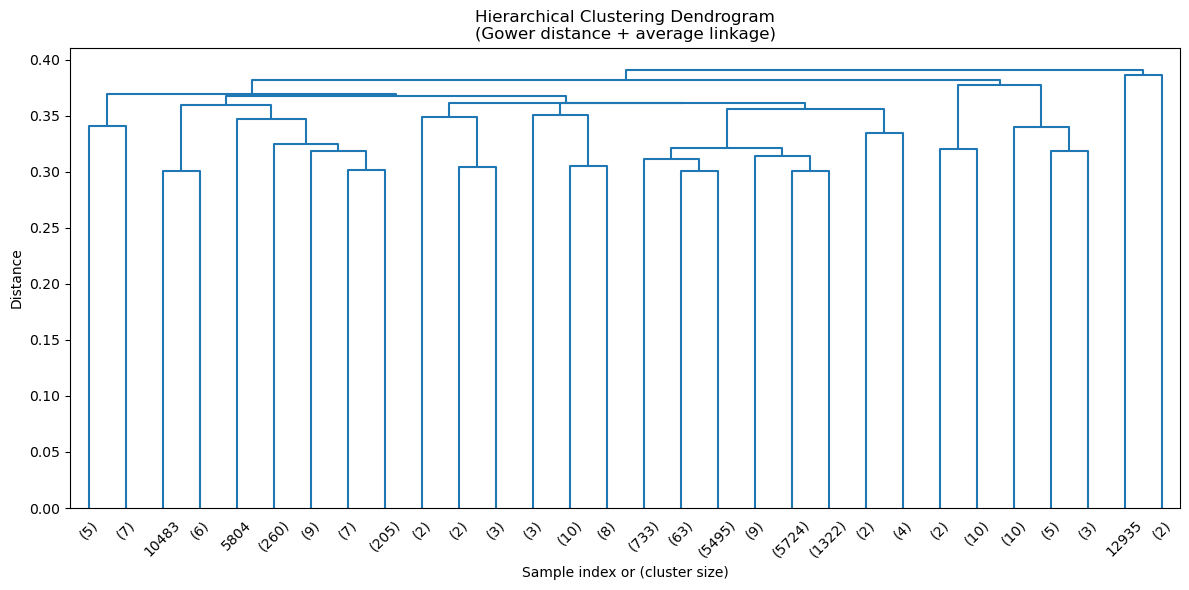

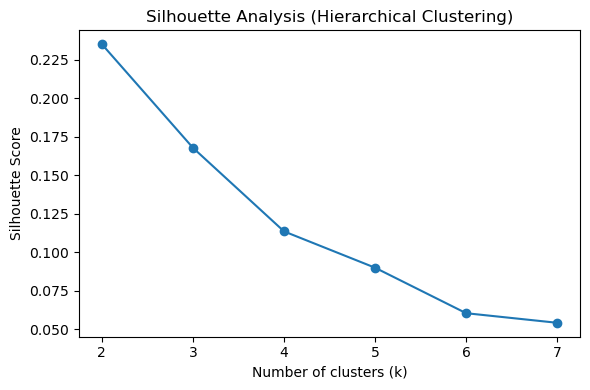

k=2, silhouette=0.235
k=3, silhouette=0.168
k=4, silhouette=0.113
k=5, silhouette=0.090
k=6, silhouette=0.060
k=7, silhouette=0.054

Final Cluster Counts:
Cluster
1    13911
2        3
Name: count, dtype: int64

Cluster Means (All Columns):
         C Television  C Police  C Courts  C Government  C Political parties  \
Cluster                                                                        
1            2.773417  2.191863  2.294228      2.736468             2.986773   
2            2.000000  3.000000  1.333333      3.333333             3.000000   

         C Civil services  C Elections  Importance of democracy  \
Cluster                                                           
1                2.461218     2.459277                 8.625045   
2                4.000000     3.000000                 4.333333   

         Scale of incomes  Strong Leader  Expert Non Govt Person  \
Cluster                                                            
1                5.197613       3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Install gower if not installed (you can run this once)
# !pip install gower
import gower

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform  # to convert square to condensed form
from sklearn.metrics import silhouette_score

##############################################################################
# 1) Load Data
##############################################################################
wave7_csv = "data/preprocessed/cleaned_wave_7_rq2.csv"
df = pd.read_csv(wave7_csv, low_memory=True)

##############################################################################
# 2) Filter for G8 Countries
##############################################################################
g8_countries = [840, 124, 250, 276, 380, 392, 643, 826]
df_g8 = df[df["Country"].isin(g8_countries)].copy()

##############################################################################
# 3) Replace coded missing values with NaN
##############################################################################
missing_values = [-1, -2, -4, -5]
df_g8.replace(missing_values, np.nan, inplace=True)

##############################################################################
# 4) Separate Columns by Type
##############################################################################
ordinal_cols = [
    "C Television", "C Police", "C Courts", "C Government",
    "C Political parties", "C Civil services", "C Elections",
    "Importance of democracy", "Scale of incomes",
    "Strong Leader", "Expert Non Govt Person"
]

categorical_cols = ["Highest educational level", "Sex", 
                    "Signing a petition", "Joining unofficial strikes"]

numeric_col = ["Age"]

all_features = ordinal_cols + categorical_cols + numeric_col
df_cluster = df_g8[all_features].copy()

##############################################################################
# 5) Handle Missing Values
##############################################################################
from pandas.api.types import is_numeric_dtype

for col in ordinal_cols + numeric_col:
    if is_numeric_dtype(df_cluster[col]):
        median_val = df_cluster[col].median()
        df_cluster.loc[df_cluster[col].isnull(), col] = median_val

for col in categorical_cols:
    mode_val = df_cluster[col].mode(dropna=True)
    if not mode_val.empty:
        df_cluster.loc[df_cluster[col].isnull(), col] = mode_val[0]

##############################################################################
# 6) Encode Columns
##############################################################################
# --- 6A) Ordinal Columns ---
for col in ordinal_cols:
    df_cluster[col] = df_cluster[col].astype(int)

# --- 6B) Categorical Columns ---
from sklearn.preprocessing import LabelEncoder
for col in categorical_cols:
    df_cluster[col] = df_cluster[col].astype(str)
    le = LabelEncoder()
    df_cluster[col] = le.fit_transform(df_cluster[col])
    
##############################################################################
# 7) Final Data Check
##############################################################################
print("===== Final df_cluster Info =====")
print(df_cluster.info())
print("\nSample:\n", df_cluster.head())
print("\nDescription:\n", df_cluster.describe())

##############################################################################
# 8) Compute Gower Distance
##############################################################################
print("\nComputing Gower distance... This may take a while for large datasets.")
gower_dist = gower.gower_matrix(df_cluster)

# Convert the square distance matrix to a condensed distance matrix
condensed_gower = squareform(gower_dist)

##############################################################################
# 9) Hierarchical Clustering using the condensed distance matrix
##############################################################################
print("Performing hierarchical clustering...")
Z = linkage(condensed_gower, method="average")

# --- 9A) Plot the Dendrogram ---
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30)  # show only last 30 merges for readability
plt.title("Hierarchical Clustering Dendrogram\n(Gower distance + average linkage)")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

##############################################################################
# 10) Silhouette Analysis to choose k
##############################################################################
k_values = range(2, 8)  # you can adjust this range
sil_scores = []

for k in k_values:
    cluster_labels = fcluster(Z, t=k, criterion="maxclust")
    s = silhouette_score(gower_dist, cluster_labels, metric="precomputed")
    sil_scores.append(s)

plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis (Hierarchical Clustering)")
plt.tight_layout()
plt.show()

for kv, sc in zip(k_values, sil_scores):
    print(f"k={kv}, silhouette={sc:.3f}")

##############################################################################
# 11) Assign Final Clusters
##############################################################################
# Suppose we choose k=3 based on silhouette or dendrogram interpretation
best_k = 5
cluster_labels_final = fcluster(Z, t=best_k, criterion="maxclust")
df_cluster["Cluster"] = cluster_labels_final

print("\nFinal Cluster Counts:")
print(df_cluster["Cluster"].value_counts())

##############################################################################
# 12) Examine Cluster Profiles
##############################################################################
print("\nCluster Means (All Columns):")
print(df_cluster.groupby("Cluster").mean())

# For a more detailed view, you can inspect ordinal, categorical, and numeric groups separately:
print("\nOrdinal Variables Means by Cluster:")
print(df_cluster.groupby("Cluster")[ordinal_cols].mean())

print("\nNumeric Variable (Age) Means by Cluster:")
print(df_cluster.groupby("Cluster")[numeric_col].mean())

print("\nCategorical (Encoded) Variables Means by Cluster:")
print(df_cluster.groupby("Cluster")[categorical_cols].mean())

##############################################################################
# End of Script
##############################################################################
